In [1]:
import json
import torch

import pickle

from Utils.ChessUtils import *

CTU = ChessTensorUtils()

ModuleNotFoundError: No module named 'Utils'

In [5]:
with open("annotations.json") as f:
    data = json.load(f)

In [6]:
data.keys(), data["annotations"].keys(), len(data["annotations"]["corners"]), len(data["images"])

(dict_keys(['info', 'images', 'annotations', 'categories', 'splits']),
 dict_keys(['pieces', 'corners']),
 2078,
 10800)

In [ ]:
red2k = data["splits"]["chessred2k"]

red2k = red2k["train"]["image_ids"] + red2k["val"]["image_ids"] + red2k["test"]["image_ids"]

2078

In [28]:
out = {}
def add_data(img_id, key, value):
    if not(img_id in out):
        out[img_id] = {}
    out[img_id][key] = value

In [29]:
for img in data["images"]:
    add_data(img["id"], "image_id", img["id"])
    add_data(img["id"], "file_path", img["path"])
    add_data(img["id"], "game_id", img["game_id"])
    add_data(img["id"], "move_id", img["move_id"])

In [30]:
for cor in data["annotations"]["corners"]:
    c = cor["corners"]
    corners = [c["top_left"], c["top_right"], c["bottom_right"], c["bottom_left"]]
    add_data(cor["image_id"], "corners", corners)

In [31]:
files = list('abcdefgh')
ranks = list('12345678')
piece_types = [0,2,3,1,4,5,6,8,9,7,10,11,12]

grids = {}
for piece in data["annotations"]["pieces"]:
    i_id = piece["image_id"]
    if not(i_id in grids):
        grids[i_id] = [[12] * 8 for _ in range(8)]

    file, rank = list(piece["chessboard_position"])
    file, rank = files.index(file), ranks.index(rank)

    p_type = piece_types.index(piece["category_id"])

    grids[i_id][rank][file] = p_type

In [32]:
for idx in grids:
    f = CTU.tensorToFEN_MAX(torch.tensor(grids[idx]).unsqueeze(dim=0))
    add_data(idx, "fen", f)

In [33]:
out[0]

{'image_id': 0,
 'file_path': 'images/0/G000_IMG000.jpg',
 'game_id': 0,
 'move_id': 0,
 'corners': [[488.7, 1078.7],
  [1772.23, 638.59],
  [2610.3, 1560.9],
  [1063.3, 2304.1]],
 'fen': 'RNBQKBNR/PPPPPPPP/8/8/8/8/pppppppp/rnbqkbnr'}

In [34]:
with open("annotations_cleaned.json", "w") as f:
    f.write(json.dumps(out))

In [35]:
for idx in out:
    one_hot_board = CTU.FENtoTensor(out[idx]["fen"])
    int_board = CTU.onehot_to_int(one_hot_board)
    add_data(idx, "board_tensor", int_board)
    add_data(idx, "board_tensor_one_hot", one_hot_board)

In [49]:
res = []
for key in out:
    res.append(out[key])

In [50]:
with open("annotations.pkl", "wb") as f:
    pickle.dump(res, f)

In [51]:
with open("annotations.pkl", "rb") as f:
    out_2 = pickle.load(f)

In [52]:
type(out), type(out_2), type(res)

(dict, list, list)

In [53]:
out_red2k = []
for img in out_2:
    idx = img["image_id"]
    if (idx in out_red2k):
        out_red2k.append(img)

with open("annotations_2k.pkl", "wb") as f:
    pickle.dump(out, f)

In [1]:
from ChessReD_Dataset import *
from matplotlib import pyplot as plt

In [2]:
CRD = ChessReDDataset()
# CRD = ChessReDDataset(label_key="fen")
dataLoader = CRD.getLoader()

In [3]:
len(CRD)

2078

In [3]:
for X, y in dataLoader:
    break

'RNBQKBNR/PP2PP1P/6P1/8/2pP4/3p1n2/pp3ppp/rnbqkb1r'

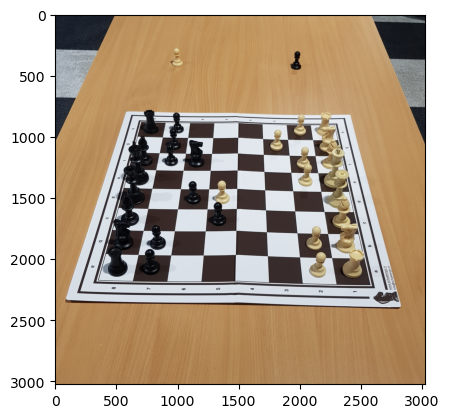

In [4]:
plt.imshow(X[0]);
y[0]

In [6]:
# labels_file_path = "chessred_annotations.pkl"
labels_file_path = "chessred2k_annotations.pkl"
with open(labels_file_path, "rb") as f:
    labels: list = pickle.load(f)

for i in range(len(labels)):
    if "corners" in labels[i]:
        labels[i]["corners"] = torch.tensor(labels[i]["corners"])

In [7]:
with open(labels_file_path, "wb") as f:
    pickle.dump(labels, f)